# Data Analysis

In [37]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import cv2
import os
from glob import glob
from IPython.display import Image, display
import warnings
warnings.filterwarnings('ignore')

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Scikit-learn imports
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Keras imports (for backwards compatibility)
from keras.models import load_model
from keras.applications import DenseNet121 as KerasDenseNet121
from keras.preprocessing import image as keras_image
from keras.metrics import binary_accuracy


Eploration

In [19]:
df1= pd.read_csv('NIH Chest X-rays/Data_Entry_2017.csv')

In [3]:
print('shape of data : ',df1.shape)

shape of data :  (112120, 12)


In [4]:
df1.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,NaN


In [5]:
df1.describe()

,Follow-up #,Patient ID,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


check duplicated

In [6]:
df1.duplicated().sum()

0

check for null values

In [7]:
df1.isnull().sum()

Image Index                         0
Finding Labels                      0
Follow-up #                         0
Patient ID                          0
Patient Age                         0
Patient Gender                      0
View Position                       0
OriginalImage[Width                 0
Height]                             0
OriginalImagePixelSpacing[x         0
y]                                  0
Unnamed: 11                    112120
dtype: int64

In [8]:
df1=df1[['Finding Labels','Follow-up #','Patient ID', 'Patient Age', 'Patient Gender']]

In [9]:
# rows having no. of disease
df1['Labels_Count'] = df1['Finding Labels'].apply(lambda text: len(text.split('|')) if(text != 'No Finding') else 0)

Bar Plot of the values 

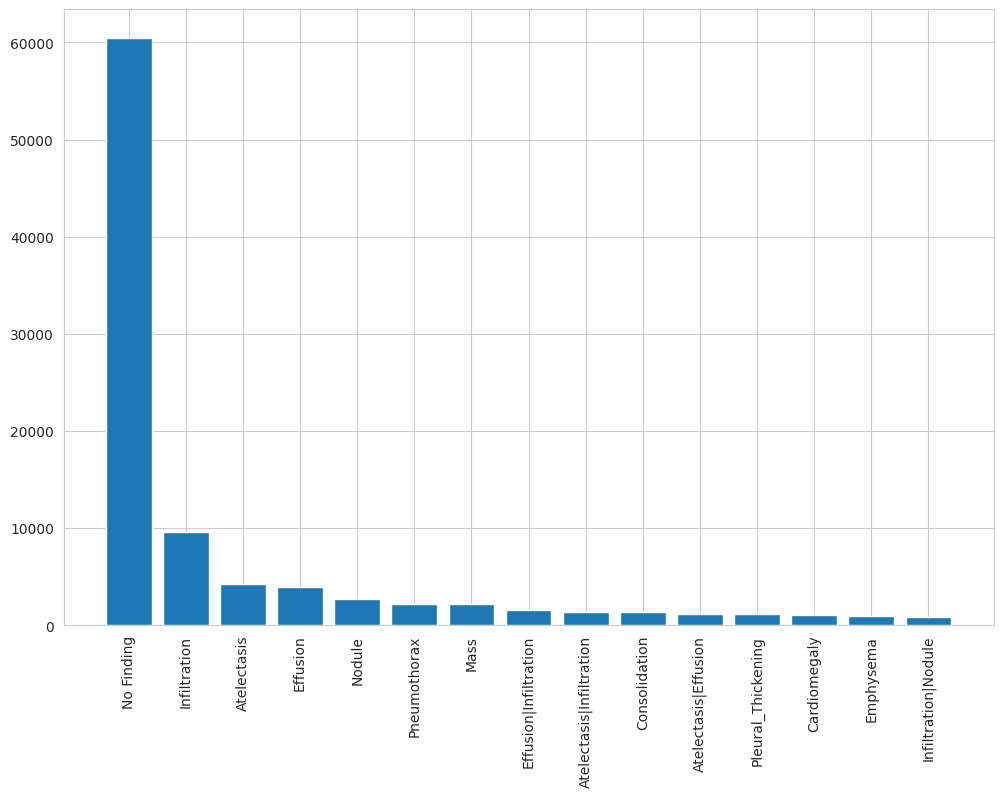

In [10]:
import matplotlib.pyplot as plt
import numpy as np
label_counts = df1['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [11]:
# Convert 'Patient Age' column to numeric, coercing errors to NaN
df1['Patient Age'] = pd.to_numeric(df1['Patient Age'], errors='coerce')

# Filter out rows where 'Patient Age' is less than 100
total = len(df1)
print('No. of rows before removing rows having age > 100 : ', total)

df1 = df1[df1['Patient Age'] < 100]

print('No. of rows after removing rows having age > 100 : ', len(df1))
print('No. of datapoints having age > 100 : ', total - len(df1))


No. of rows before removing rows having age > 100 :  112120
No. of rows after removing rows having age > 100 :  0
No. of datapoints having age > 100 :  112120


create column for each disease

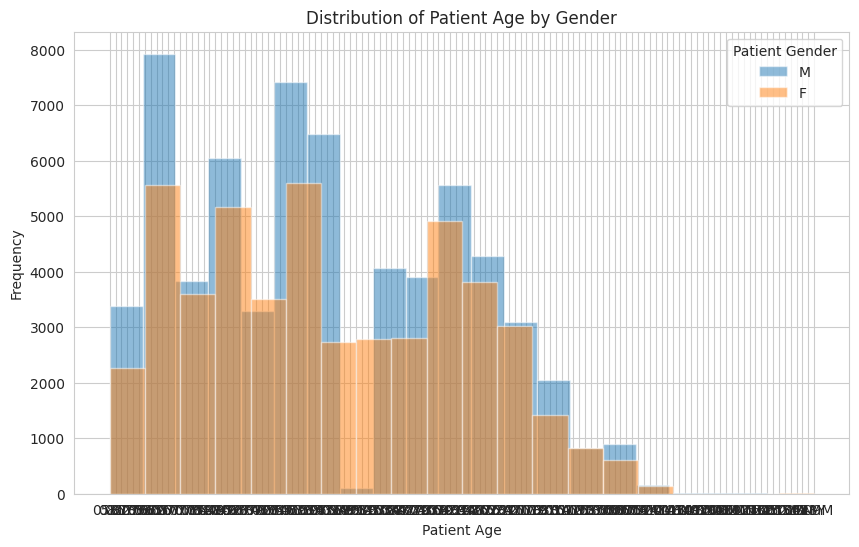

In [20]:
import matplotlib.pyplot as plt

# Check for the necessary columns and plot data
if 'Patient Age' in df1.columns and 'Patient Gender' in df1.columns:
    genders = df1['Patient Gender'].unique()
    
    plt.figure(figsize=(10, 6))
    
    for gender in genders:
        subset = df1[df1['Patient Gender'] == gender]
        plt.hist(subset['Patient Age'], bins=20, alpha=0.5, label=gender)
    
    plt.xlabel('Patient Age')
    plt.ylabel('Frequency')
    plt.legend(title='Patient Gender')
    plt.title('Distribution of Patient Age by Gender')
    plt.show()
else:
    print("Columns 'Patient Age' or 'Patient Gender' not found in DataFrame.")


Patient AgeObservation - Both the gender have almost same distribution

create column for each disease

In [23]:
diseases =['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 
          'Fibrosis', 'Effusion','Pneumonia','Pleural_Thickening','Cardiomegaly','Nodule Mass','Hernia']
for disease in diseases :
  df1[disease] = df1['Finding Labels'].apply(lambda x: 1 if disease in x else 0)

Patient Age

In [24]:
df1.shape

(112120, 25)

Disease distribution by age and sex

ValueError: min() arg is an empty sequence

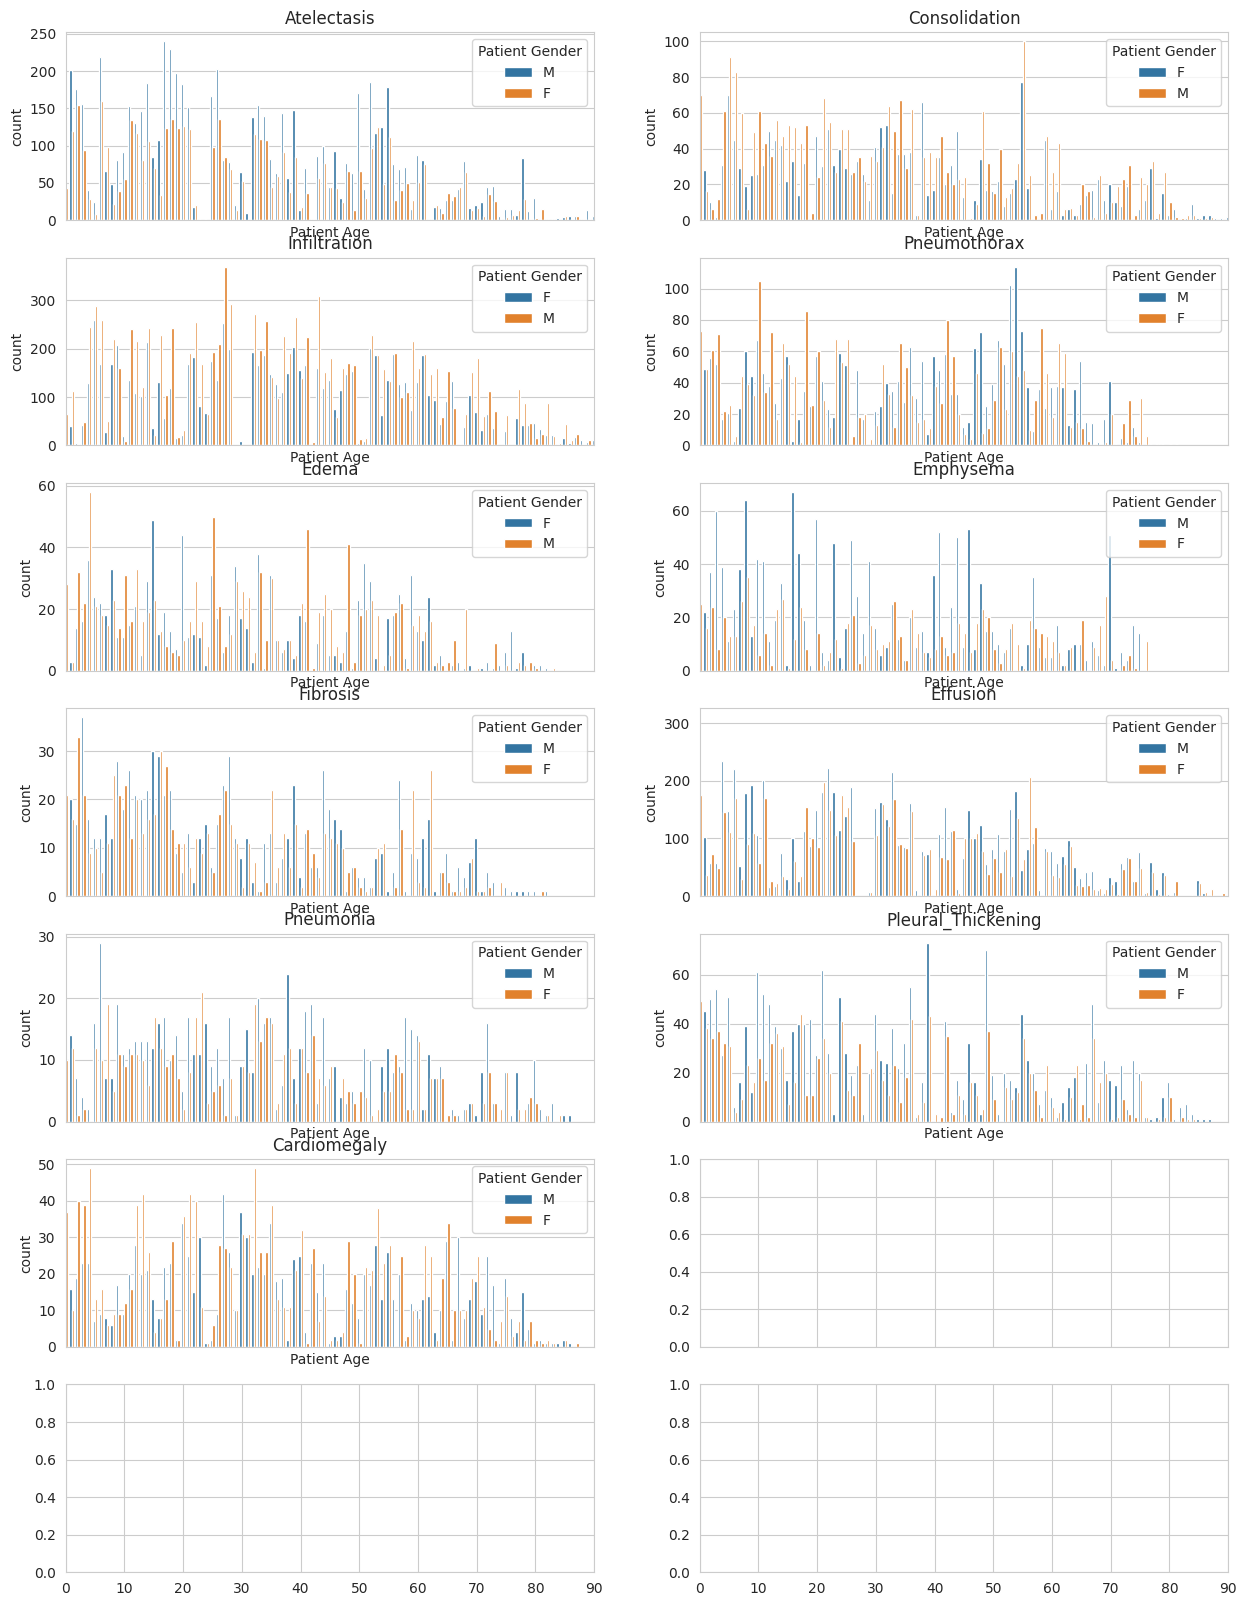

In [25]:

f, axarr = plt.subplots(7, 2, sharex=True,figsize=(15, 20))
i=0
j=0
x=np.arange(0,100,10)
for disease in diseases :
    index = []
    for k in range(len(df1)):
        if disease in df1.iloc[k]['Finding Labels']:
            index.append(k)
    g=sns.countplot(x='Patient Age', hue="Patient Gender",data=df1.iloc[index], ax=axarr[i, j])
    axarr[i, j].set_title(disease)   
    g.set_xlim(0,90)
    g.set_xticks(x)
    g.set_xticklabels(x)
    j=(j+1)%2
    if j==0:
        i=(i+1)%7
f.subplots_adjust(hspace=0.3)

No. of each disease by patient gender

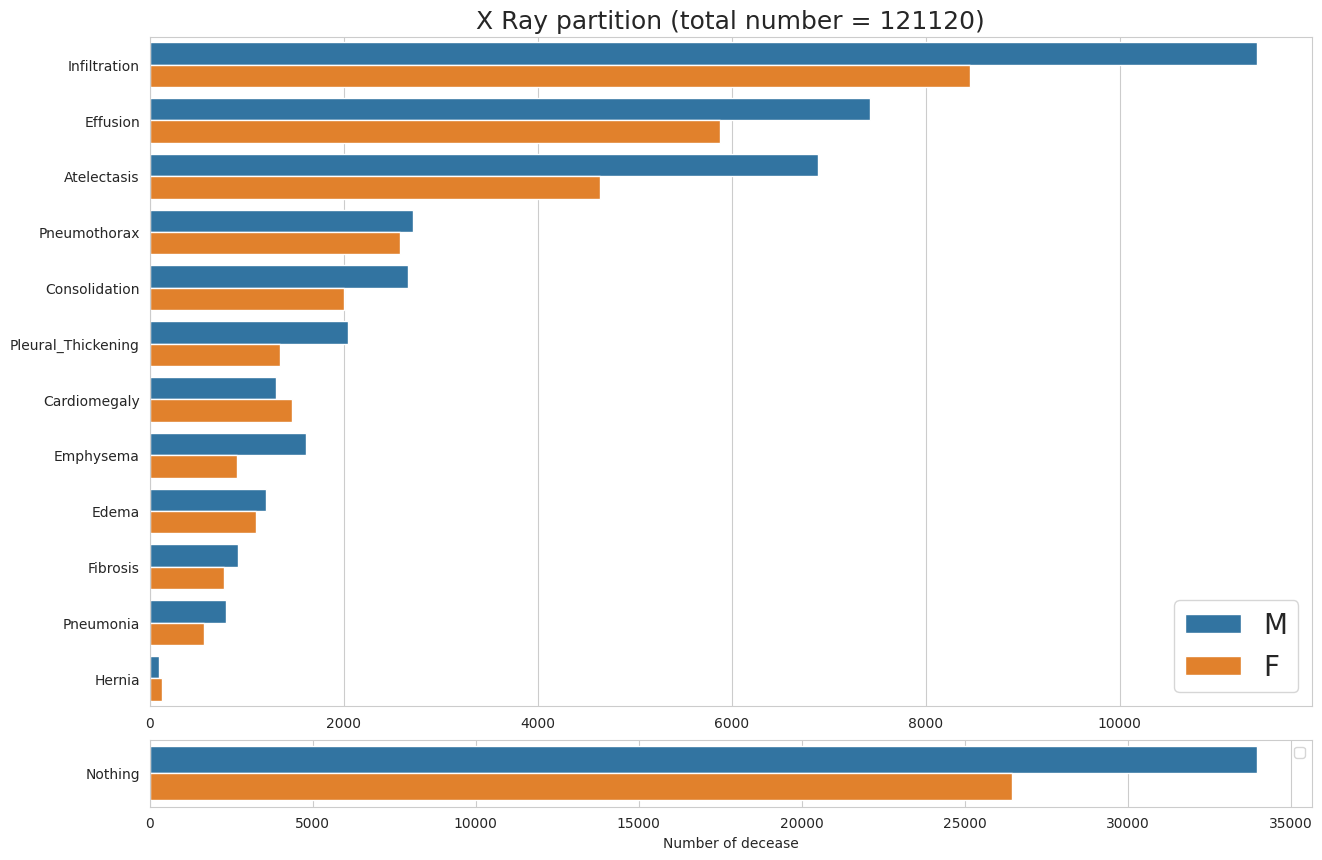

In [28]:
plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(8,1)
ax1 = plt.subplot(gs[:7, :])
ax2 = plt.subplot(gs[7, :])
data1 = pd.melt(df1,
             id_vars=['Patient Gender'],
             value_vars = list(diseases),
             var_name = 'Category',
             value_name = 'Count')
data1 = data1.loc[data1.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data1, ax=ax1, order = data1['Category'].value_counts().index)
ax1.set( ylabel="",xlabel="")
ax1.legend(fontsize=20)
ax1.set_title('X Ray partition (total number = 121120)',fontsize=18);

df1['Nothing']=df1['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

data2 = pd.melt(df1,
             id_vars=['Patient Gender'],
             value_vars = list(['Nothing']),
             var_name = 'Category',
             value_name = 'Count')
data2 = data2.loc[data2.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data2,ax=ax2)
ax2.set( ylabel="",xlabel="Number of decease")
ax2.legend('')
plt.subplots_adjust(hspace=.5)

age distribution by sex

ValueError: The number of FixedLocator locations (121), usually from a call to set_ticks, does not match the number of labels (100).

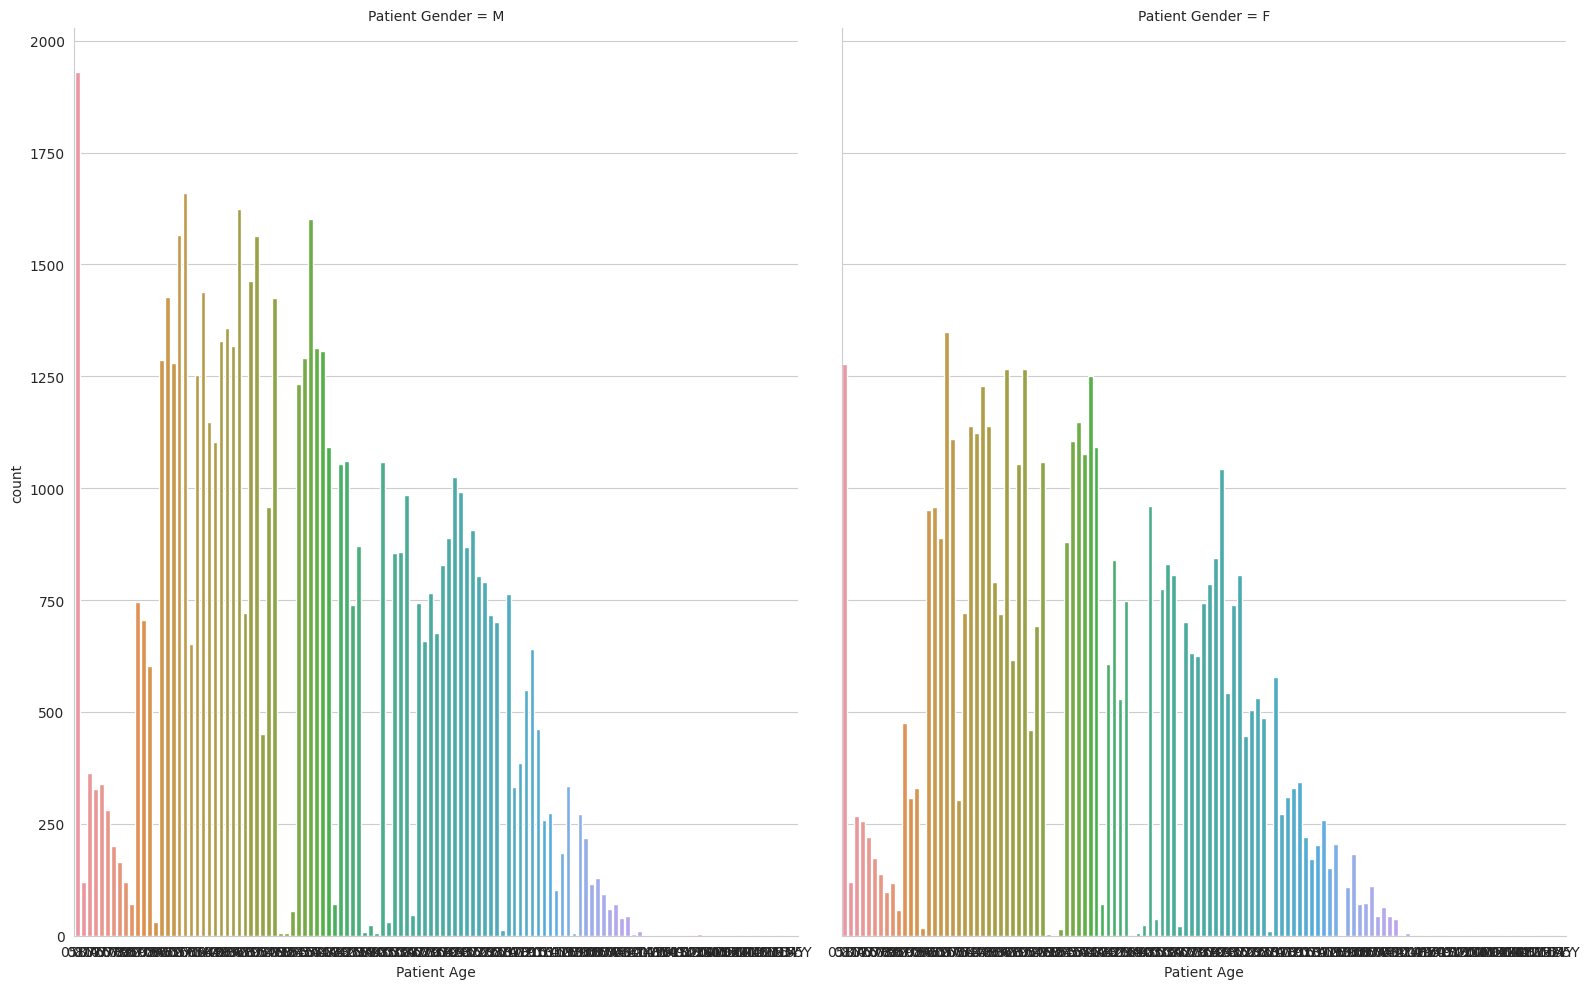

In [30]:
#g = sns.catplot(x="Patient Age", col="Patient Gender",data=df1, kind="count",size=10, aspect=0.8,palette="GnBu_d");
g = sns.catplot(x="Patient Age", col="Patient Gender", data=df1, kind="count", height=10, aspect=0.8)
g.set_xticklabels(np.arange(0,100));
g.set_xticklabels(step=10);
g.fig.suptitle('Age distribution by sex',fontsize=22);
g.fig.subplots_adjust(top=.9)

ValueError: The number of FixedLocator locations (121), usually from a call to set_ticks, does not match the number of labels (100).

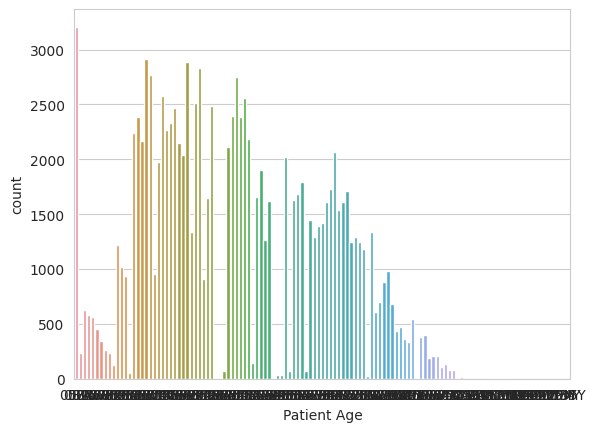

In [31]:
g= sns.countplot(x="Patient Age", data=df1)
g.set_xticklabels(np.arange(0,100));
g.set_xticklabels(step=10);

ratio between one and multiple disease

In [33]:
df=df1.groupby('Finding Labels').count().sort_values('Patient ID',ascending=False)
df1=df[['|' in index for index in df.index]].copy()
df2=df[['|' not in index for index in df.index]]
df2=df2[['No Finding' not in index for index in df2.index]]
df2['Finding Labels']=df2.index.values
df1['Finding Labels']=df1.index.values

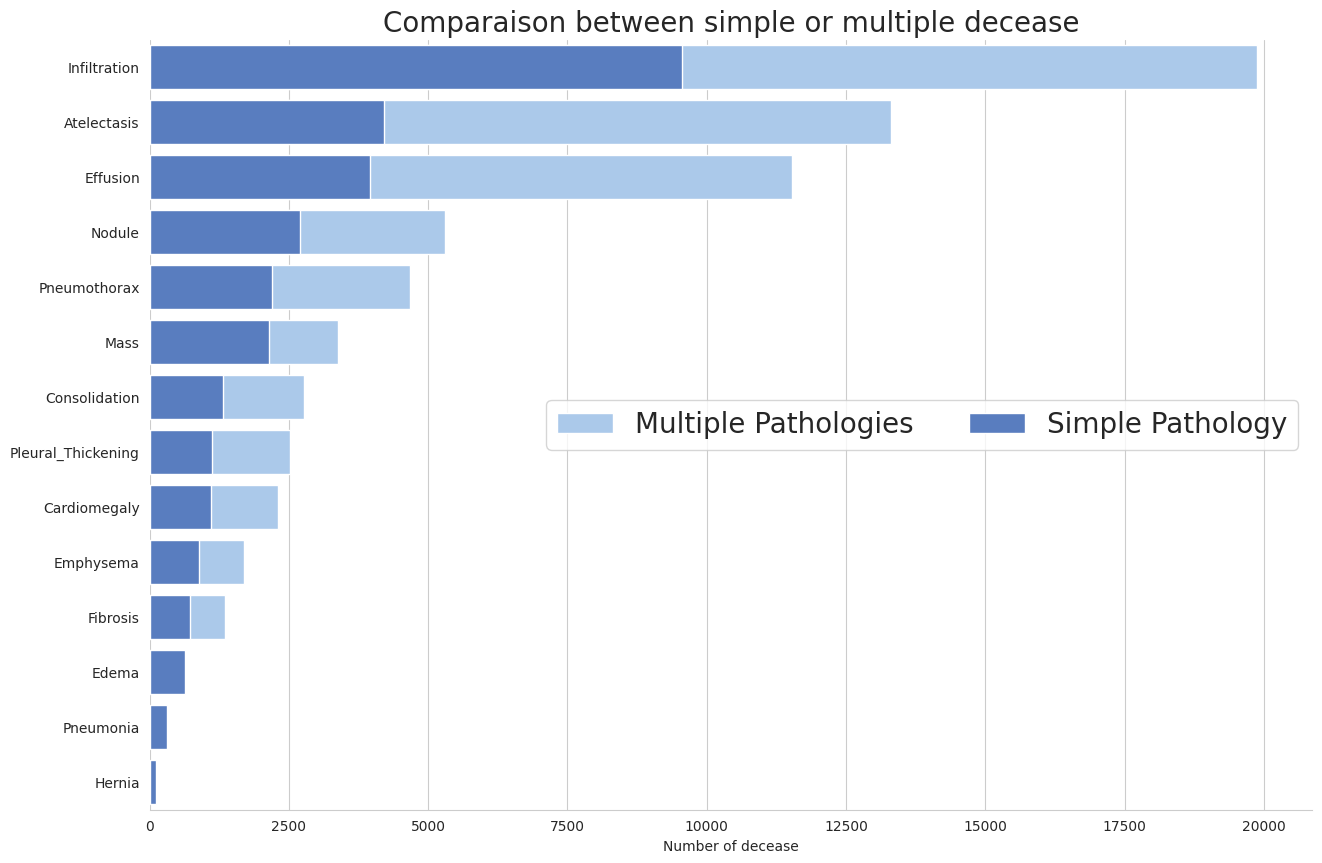

In [34]:
f, ax = plt.subplots(sharex=True,figsize=(15, 10))
sns.set_color_codes("pastel")
g=sns.countplot(y='Category',data=data1, ax=ax, order = data1['Category'].value_counts().index,color='b',label="Multiple Pathologies")
sns.set_color_codes("muted")
g=sns.barplot(x='Patient ID',y='Finding Labels',data=df2, ax=ax, color="b",label="Simple Pathology")
ax.legend(ncol=2, loc="center right", frameon=True,fontsize=20)
ax.set( ylabel="",xlabel="Number of decease")
ax.set_title("Comparaison between simple or multiple decease",fontsize=20)      
sns.despine(left=True)


 Plot most important pathologies groups for each desease

In [35]:
#we just keep groups of pathologies which appear more than 30 times
df3=df1.loc[df1['Patient ID']>30,['Patient ID','Finding Labels']]

for pathology in diseases:
    df3[pathology]=df3.apply(lambda x: x['Patient ID'] if pathology in x['Finding Labels'] else 0, axis=1)

df3.head(20)

,Patient ID,Finding Labels,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule Mass,Hernia
Finding Labels,,,,,,,,,,,,,,,
Effusion|Infiltration,1602,Effusion|Infiltration,0,0,1602,0,0,0,0,1602,0,0,0,0,0
Atelectasis|Infiltration,1356,Atelectasis|Infiltration,1356,0,1356,0,0,0,0,0,0,0,0,0,0
Atelectasis|Effusion,1167,Atelectasis|Effusion,1167,0,0,0,0,0,0,1167,0,0,0,0,0
Infiltration|Nodule,829,Infiltration|Nodule,0,0,829,0,0,0,0,0,0,0,0,0,0
Atelectasis|Effusion|Infiltration,740,Atelectasis|Effusion|Infiltration,740,0,740,0,0,0,0,740,0,0,0,0,0
Cardiomegaly|Effusion,483,Cardiomegaly|Effusion,0,0,0,0,0,0,0,483,0,0,483,0,0
Consolidation|Infiltration,442,Consolidation|Infiltration,0,442,442,0,0,0,0,0,0,0,0,0,0
Infiltration|Mass,420,Infiltration|Mass,0,0,420,0,0,0,0,0,0,0,0,0,0
Effusion|Pneumothorax,405,Effusion|Pneumothorax,0,0,0,405,0,0,0,405,0,0,0,0,0


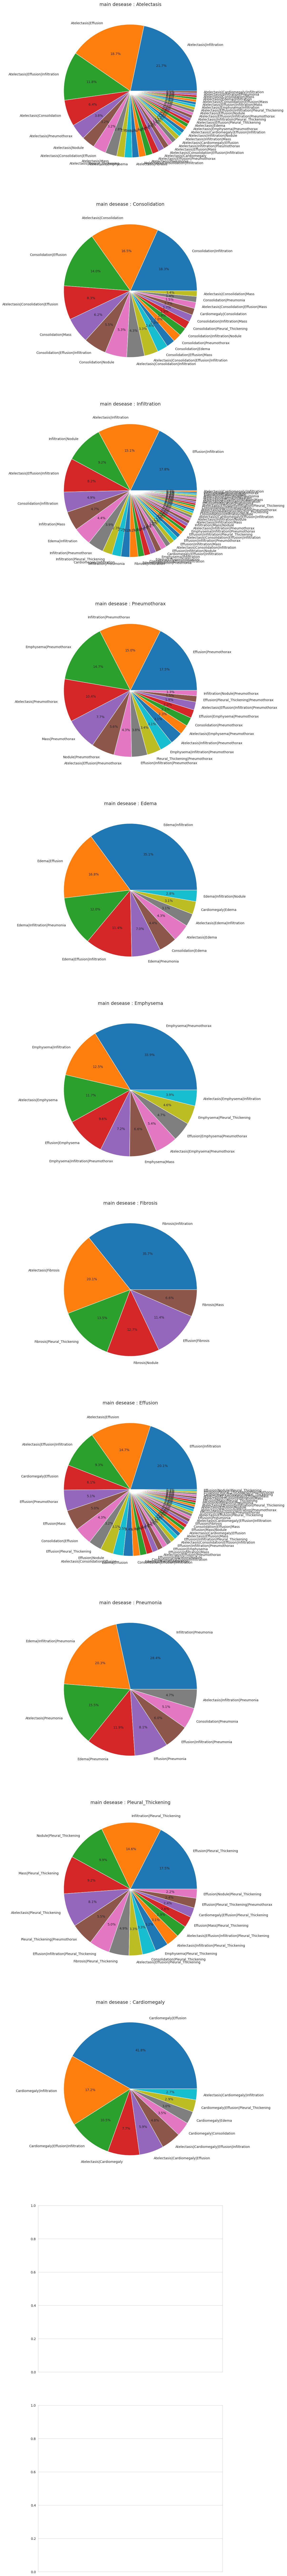

In [36]:
#'Hernia' has not enough values to figure here
df4=df3[df3['Hernia']>0]  # df4.size == 0
#remove 'Hernia' from list
pat_list=[elem for elem in diseases if 'Hernia' not in elem]

f, axarr = plt.subplots(13, sharex=True,figsize=(10, 140))
i=0
for pathology in pat_list :
    df4=df3[df3[pathology]>0]
    if df4.size>0:  #'Hernia' has not enough values to figure here
        axarr[i].pie(df4[pathology],labels=df4['Finding Labels'], autopct='%1.1f%%')
        axarr[i].set_title('main desease : '+pathology,fontsize=14)   
        i +=1

We can see that some pathologies seem to appear with all kind of pathology:



*   Effusion
* Aletectasis
Infiltration Some others seem to have favorite couple:
* Cardiomegaly with Effusion
* Emphysema with Pneumothorax
* Nodule with Infiltration
* Edema with Infiltration
* Fibrosis with Infiltration
* Pneumonia with Infiltration
*   List item



# Data PreProcessing


In [38]:
xray_data = pd.read_csv('NIH Chest X-rays/Data_Entry_2017.csv')
num_obs = len(xray_data)
print('Number of observations:',num_obs)
xray_data.head()

Number of observations: 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,NaN


In [40]:
from glob import glob
my_glob = glob('nih/images*/images/*.png')
print('Number of images: ', len(my_glob)) 

Number of images:  112120


In [42]:
# Map the image paths onto xray_data
full_img_paths = {os.path.basename(x): x for x in my_glob}
xray_data['full_path'] = xray_data['Image Index'].map(full_img_paths.get)

In [43]:
xray_data.shape

(112120, 13)

In [44]:
dropLabels = ['Image Index', 'Follow-up #', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11']
xray_data.drop(columns = dropLabels, inplace = True)

In [45]:
xray_data.shape

(112120, 3)

In [46]:
xray_data.head()

,Finding Labels,Patient ID,full_path
0,Cardiomegaly,1,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...
1,Cardiomegaly|Emphysema,1,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...
2,Cardiomegaly|Effusion,1,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...
3,No Finding,2,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...
4,Hernia,3,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...


In [ ]:
#xray_data.to_csv('NIH/xray_data.csv', index=False)
#xray_data = pd.read_csv('NIH/xray_data.csv')

In [47]:
xray_data['Finding Labels'] = xray_data['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*xray_data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        xray_data[c_label] = xray_data['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
xray_data.shape

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


(112120, 17)

# Splitting The Data

In [18]:
df= xray_data

# Check for duplicates in the 'Patient ID' column
print(any(df['Patient ID'].duplicated()))

# Check for missing values in the 'Patient ID' column
print(df['Patient ID'].isna().sum())

True
0


In [19]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets based on the 'id' column
train_ids, test_ids = train_test_split(df['Patient ID'].unique(), test_size=0.2, random_state=2024)

# Split the train data further into train and validation sets
train_ids, val_ids = train_test_split(train_ids, test_size=0.1, random_state=2024)

# Create train, validation, and test dataframes based on the split ids
train_df = df[df['Patient ID'].isin(train_ids)]
val_df = df[df['Patient ID'].isin(val_ids)]
test_df = df[df['Patient ID'].isin(test_ids)]
print(df.shape[0], train_df.shape[0], val_df.shape[0], test_df.shape[0])

112120 79893 8654 23573


In [20]:
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """
    
    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)
    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups)>0 
    return leakage


In [21]:
check_for_leakage(train_df, val_df, 'Patient ID')
check_for_leakage(train_df, val_df, 'Patient ID')
check_for_leakage(val_df, test_df, 'Patient ID')

False

In [22]:
# print the number of rows in each set
print(f'Train set: {train_df.shape[0]} rows')
print(f'Validation set: {val_df.shape[0]} rows')
print(f'Test set: {test_df.shape[0]} rows')

Train set: 79893 rows
Validation set: 8654 rows
Test set: 23573 rows


In [23]:
# print the number of rows in each set
print('Train set:', train_df['Patient ID'].nunique())
print('Validation set:', val_df['Patient ID'].nunique())
print('Test set:', test_df['Patient ID'].nunique())

Train set: 22179
Validation set: 2465
Test set: 6161


In [24]:
print('train', train_df.shape[0],'vald:',val_df.shape[0], 'test:', test_df.shape[0])

train 79893 vald: 8654 test: 23573


In [25]:

train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)
val_df.to_csv('validation.csv', index=False)

In [27]:
labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema',
          'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass','Hernia']

In [28]:
print('train', train_df.shape[0],'vald:',val_df.shape[0], 'test:', test_df.shape[0])

train 79893 vald: 8654 test: 23573
